# Illustrated Responses with Claude

In this recipe, we'll show how to make an instantiation of Claude that illustrates its responses by calling an image generation tool. We'll do this in three steps:
1. Connect to the Stable Diffusion API
2. Write a prompt that explains to Claude how and when to call the API
3. Ask Claude some questions and see how it answers!

In [2]:
import os, re, requests, anthropic
from IPython import display
from base64 import b64decode

In [3]:
STABILITY_API_KEY = "" # Stability API key goes here
ANTHROPIC_API_KEY = "" # Anthropic API key goes here
MODEL_NAME = "claude-3-opus-20240229"
CLIENT = anthropic.Anthropic(api_key=ANTHROPIC_API_KEY)

In [4]:
def gen_image(prompt, height=1024, width=1024, num_samples=1):
    engine_id = "stable-diffusion-v1-6"
    api_host = 'https://api.stability.ai'

    response = requests.post(
        f"{api_host}/v1/generation/{engine_id}/text-to-image",
        headers={
            "Content-Type": "application/json",
            "Accept": "application/json",
            "Authorization": f"Bearer {STABILITY_API_KEY}"
        },
        json={
            "text_prompts": [
                {
                    "text": prompt,
                }
            ],
            "cfg_scale": 7,
            "height": height,
            "width": width,
            "samples": num_samples,
            "steps": 30,
        },
    )

    if response.status_code != 200:
        raise Exception("Non-200 response: " + str(response.text))

    data = response.json()
    return data['artifacts'][0]['base64']

In [5]:
def show_image(b64): # Helper function for displaying images in a notebook
    return display.Image(b64decode(b64))

Now, we'll write the prompt explaining to Claude how and when to call the image generator, along with some advice for writing image prompts that will lead to pretty output.

In [6]:
image_gen_system_prompt = ("You are Claude, a helpful, honest, harmless AI assistant. "
"One special thing about this conversation is that you have access to an image generation API, "
"so you may create images for the user if they request you do so, or if you have an idea "
"for an image that seems especially pertinent or profound. However, it's also totally fine "
"to just respond to the human normally if that's what seems right! If you do want to generate an image, "
"write '<function_call>create_image(PROMPT)</function_call>', replacing PROMPT with a description of the image you want to create.")

image_gen_system_prompt += """

Here is some guidance for getting the best possible images:

<image_prompting_advice>
Rule 1. Make Your Stable Diffusion Prompts Clear, and Concise
Successful AI art generation in Stable Diffusion relies heavily on clear and precise prompts. It's essential to craft problem statements that are both straightforward and focused.

Clearly written prompts acts like a guide, pointing the AI towards the intended outcome. Specifically, crafting prompts involves choosing words that eliminate ambiguity and concentrate the AI's attention on producing relevant and striking images.
Conciseness in prompt writing is about being brief yet rich in content. This approach not only fits within the technical limits of AI systems but ensures each part of the prompt contributes meaningfully to the final image. Effective prompt creation involves boiling down complex ideas into their essence.
Prompt Example:
"Minimalist landscape, vast desert under a twilight sky."
This prompt exemplifies how a few well-chosen words can paint a vivid picture. The terms 'minimalist' and 'twilight sky' work together to set a specific mood and scene, demonstrating effective prompts creation with brevity.

Another Example:
"Futuristic cityscape, neon lights, and towering skyscrapers."
Here, the use of descriptive but concise language creates a detailed setting without overwhelming the AI. This example showcases the importance of balancing detail with succinctness in prompt structuring methods.

Rule 2. Use Detailed Subjects and Scenes to Make Your Stable Diffusion Prompts More Specific
Moving into detailed subject and scene description, the focus is on precision. Here, the use of text weights in prompts becomes important, allowing for emphasis on certain elements within the scene.

Detailing in a prompt should always serve a clear purpose, such as setting a mood, highlighting an aspect, or defining the setting. The difference between a vague and a detailed prompt can be stark, often leading to a much more impactful AI-generated image. Learning how to add layers of details without overwhelming the AI is crucial.
Scene setting is more than just describing physical attributes; it encompasses emotions and atmosphere as well. The aim is to provide prompts that are rich in context and imagery, resulting in more expressive AI art.
Prompt Example:
"Quiet seaside at dawn, gentle waves, seagulls in the distance."
In this prompt, each element adds a layer of detail, painting a serene picture. The words 'quiet', 'dawn', and 'gentle waves' work cohesively to create an immersive scene, showcasing the power of specific prompts crafting.

Another Example:
"Ancient forest, moss-covered trees, dappled sunlight filtering through leaves."
This prompt is rich in imagery and detail, guiding the AI to generate an image with depth and character. It illustrates how detailed prompts can lead to more nuanced and aesthetically pleasing results.

Rule 3. Contextualizing Your Prompts: Providing Rich Detail Without Confusion
In the intricate world of stable diffusion, the ability to contextualize prompts effectively sets apart the ordinary from the extraordinary. This part of the stable diffusion guide delves into the nuanced approach of incorporating rich details into prompts without leading to confusion, a pivotal aspect of the prompt engineering process.

Contextualizing prompts is akin to painting a picture with words. Each detail added layers depth and texture, making AI-generated images more lifelike and resonant. The art of specific prompts crafting lies in weaving details that are vivid yet coherent.
For example, when describing a scene, instead of merely stating: 
"a forest."
one might say,

"a sunlit forest with towering pines and a carpet of fallen autumn leaves."
Other Prompt Examples:
"Starry night, silhouette of mountains against a galaxy-filled sky."
This prompt offers a clear image while allowing room for the AI’s interpretation, a key aspect of prompt optimization. The mention of 'starry night' and 'galaxy-filled sky' gives just enough context without dictating every aspect of the scene.

Rule 4. Do Not Overload Your Prompt Details
While detail is desirable, overloading prompts with excessive information can lead to ambiguous results. This section of the definitive prompt guide focuses on how to strike the perfect balance.

Descriptive Yet Compact: The challenge lies in being descriptive enough to guide the AI accurately, yet compact enough to avoid overwhelming it. For instance, a prompt like, 'A serene lake, reflecting the fiery hues of sunset, bordered by shadowy hills' paints a vivid picture without unnecessary verbosity.
Precision in language is key in this segment of the stable diffusion styles. It's about choosing the right words that convey the most with the least, a skill that is essential in prompt optimization.
For example, instead of using:
"a light wind that can barely be felt but heard"
You can make it shorter:

whispering breeze
More Prompt Examples:
Sample prompt: "Bustling marketplace at sunset, vibrant stalls, lively crowds."

By using descriptive yet straightforward language, this prompt sets a vivid scene of a marketplace without overcomplicating it. It's an example of how well-structured prompts can lead to dynamic and engaging AI art.
</image_prompting_advice>

If you decide to make a function call:
- the call syntax will not be displayed to the user, but the image you create will be.
- please place the call after your text response (if any)."""

Notice that this prompt asks Claude to draw the image AFTER responding to the user. This way it's guaranteed to be relevant to the answer.

Now, we'll create a helper function that takes Claude's responses when queried with this system prompt, extracts the image prompt, and creates an image.

In [8]:
def parse_response_and_gen_image(claude_response):
    if "<function_call>" in claude_response:
        image_prompt = claude_response.split('<function_call>create_image(')[1].split(')</function_call>')[0].replace('"', '')
        base64 = gen_image(image_prompt)
    else:
        image_prompt, base64 = None, None

    function_free_claude_response = re.sub(r'<function_call>.*</function_call>', '', claude_response)
    # return the image_prompt too
    return (function_free_claude_response, image_prompt, base64)

Finally, let's put it all together.

In [9]:
def illustrator_claude(prompt):
    claude_response = CLIENT.messages.create(
        system=image_gen_system_prompt,
        model=MODEL_NAME,
        max_tokens=1024,
        messages=[
          {"role": "user", "content": prompt}
        ],
    ).content[0].text
    return parse_response_and_gen_image(claude_response)

Now we can call this function on a few different prompts and witness the results!

In [8]:
function_free_response_dino, image_prompt_dino, b64_dino = illustrator_claude(
    "When & how did the Cretaceous period end?")

In [9]:
print(function_free_response_dino)

The Cretaceous period, the last period of the dinosaur age, ended approximately 66 million years ago with a mass extinction event. This is widely believed to have been caused by an asteroid impact or series of impacts. Here are some key details about the end of the Cretaceous period:

- The period ended with the Cretaceous–Paleogene extinction event, which saw the demise of the dinosaurs (excluding birds) and many other groups. Around 75% of plant and animal species became extinct.

- The main culprit is thought to have been one or more asteroid impacts. The most widely accepted candidate is the Chicxulub crater in the Yucatan Peninsula of Mexico, which was formed by an asteroid impact around 66 million years ago. 

- Evidence suggests this impact would have thrown massive amounts of dust and debris into the atmosphere, blocking out sunlight for years. This triggered global climate changes like cooling temperatures and changes in rainfall patterns. 

- Without sunlight, photosynthesis 

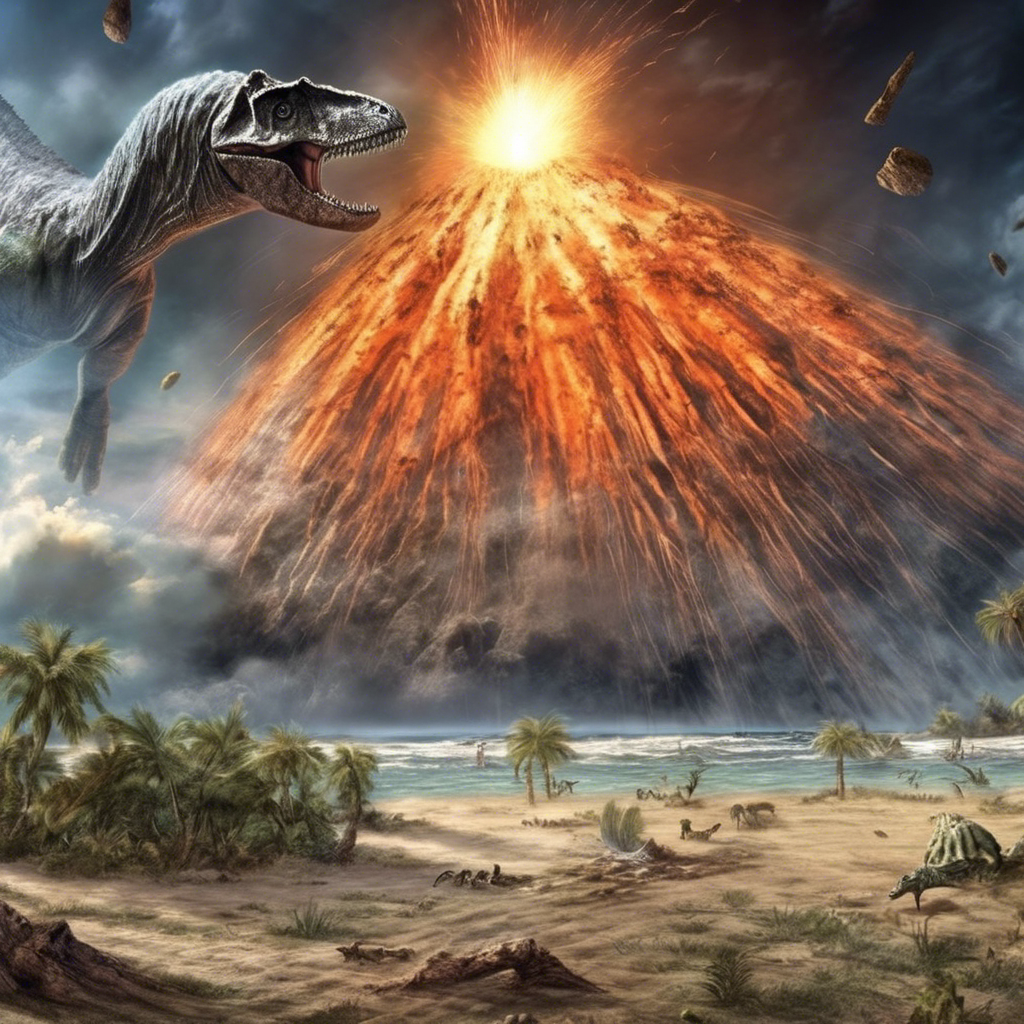

In [14]:
show_image(b64_dino)

In [11]:
print(image_prompt_dino)

An artist's illustration of the Chicxulub asteroid impact 66 million years ago, proposed to have caused the Cretaceous-Paleogene extinction event that ended the age of dinosaurs.


In [25]:
function_free_response_potato, image_prompt_potato, b64_potato = illustrator_claude(
    "What should I make for dinner? I have a bunch of potatoes and eggplant lying around. Gimme your best dish!")

In [26]:
print(function_free_response_potato)

Here is a delicious and easy recipe you could make with potatoes and eggplant:

Potato and Eggplant Gratin

Ingredients:
- 1 1/2 lbs eggplant, sliced 
- 1 1/2 lbs potatoes, sliced
- 1 onion, thinly sliced
- 3 cloves garlic, minced
- 1 cup vegetable or chicken broth
- 1/2 cup heavy cream or half and half
- 1/2 cup grated parmesan cheese
- Salt and pepper to taste
- Fresh herbs like thyme, oregano or basil for garnish

Instructions:

1. Pre-heat oven to 375°F and grease a 9x13 inch baking dish.
2. Layer half the eggplant slices in the bottom of the dish. Season with salt and pepper.
3. Layer the onions over the eggplant. Season with salt and pepper.  
4. Layer the potato slices over the onions. Season with salt and pepper.
5. Repeat layers with remaining eggplant and potatoes. 
6. In a medium bowl, whisk the broth, cream and 1/4 cup parmesan until smooth. Pour mixture evenly over the gratin. 
7. Sprinkle the remaining 1/4 cup parmesan over the top.
8. Bake uncovered for 1 hour, or until 

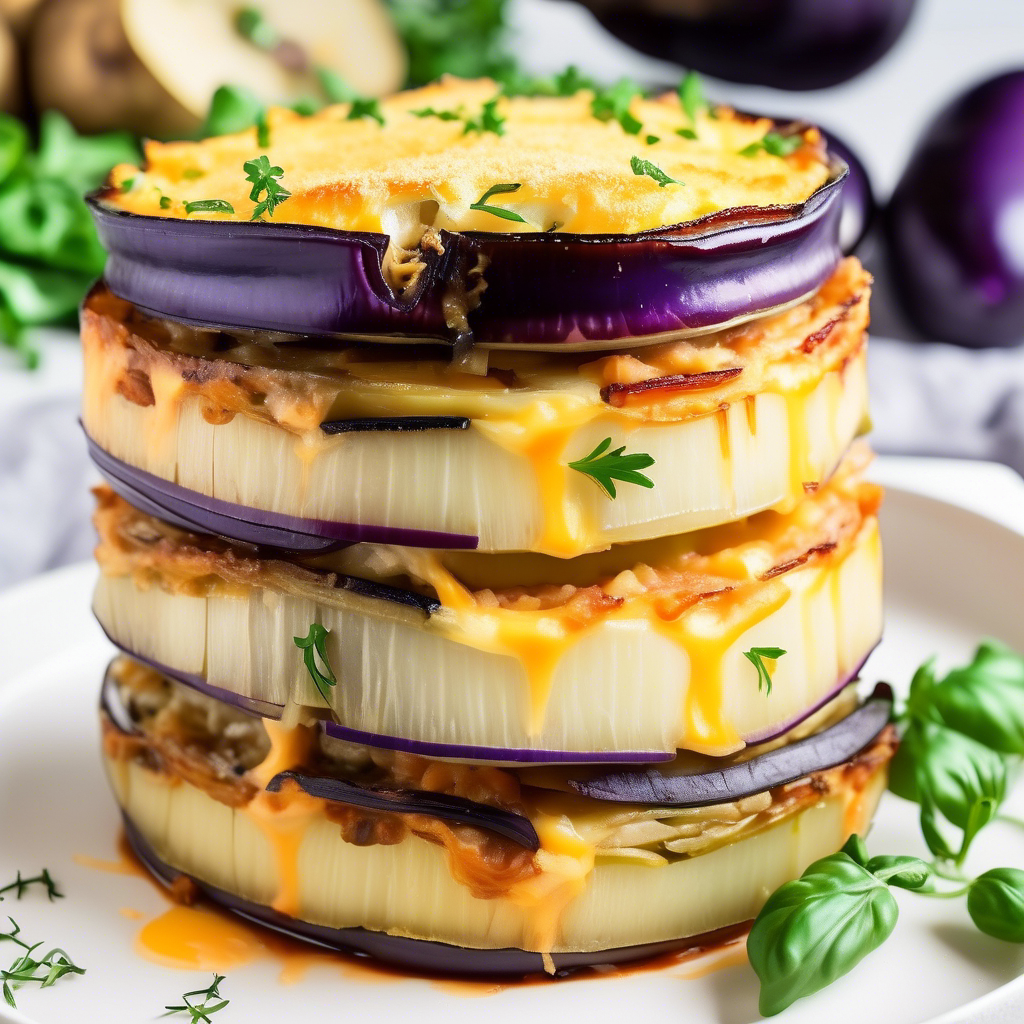

In [27]:
show_image(b64_potato)

In [28]:
print(image_prompt_potato)

A cross section view of the layered Potato and Eggplant Gratin with melted cheese on top


In [10]:
function_free_response_einstein, image_prompt_einstein, b64_einstein = illustrator_claude(
    "What would Albert Einstein look like if he were a 90s kid?")

In [11]:
print(function_free_response_einstein)

Imagining Albert Einstein as a 1990s kid is quite an amusing thought experiment! Here's how I picture it:


The juxtaposition of Einstein's iconic wild hair and scholarly demeanor with 90s youth culture fashion and interests like video games and alternative music would make for an endearing and humorous image. Depicting him in that grungy comic book art style popular in the 90s would really drive home the atmosphere too.


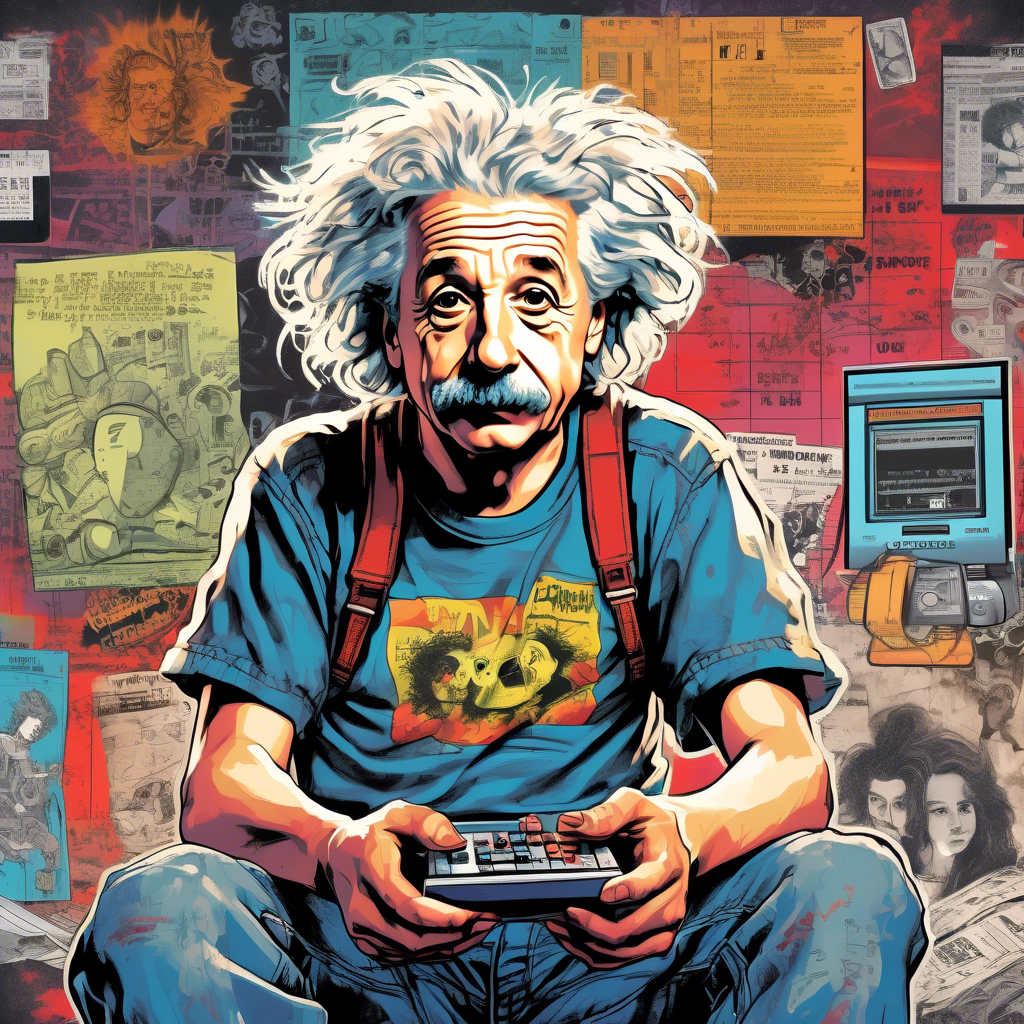

In [12]:
show_image(b64_einstein)

In [13]:
print(image_prompt_einstein)

Albert Einstein as a 1990s teenager. He has wild frizzy hair, a backwards cap, baggy jeans, and an oversized graphic tee. He sits cross-legged holding a GameBoy, with posters of grunge bands and scientific equations covering the walls behind him. Render in a grungy comic book art style with thick outlines and bright poppy colors.
